# Compare prediction

In [1]:
import sys
sys.path.insert(0,"/home/gridsan/hwpang/Software/RMG-Py/")
sys.path.insert(0,"..")

import json
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import pandas as pd
import string
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

from tree.parameters import Ts
from tree.utils import linestyles, markers

In [2]:
hbi_unc_df = pd.read_csv("../data/hbi_unc.csv")

with open("../data/splits/random.json", "r") as f:
    train_inds, test_inds = json.load(f)

num_training = len(train_inds)

test_df = hbi_unc_df.loc[test_inds, :]
test_df = test_df.reset_index(drop=True)

# Load test results

In [3]:
sidt_df_dict = {}
fractions = [0.001, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
run_dirs = {
    "../models/split-random_run-basecase": "BC",
    "../models/split-random_run-basecase-bounded": "BC_UB",
    # "../models/split-random_run-aleatoric-prepruning-bounded": "AP_UB",
    # "../models/split-random_run-model_variance_prepruning_0.05-upper_bound": "MP0.05_UB",
    # "../models/split-random_run-model_variance_prepruning_0.005-upper_bound": "MP0.005_UB",
    # "../models/split-random_run-model_variance_prepruning_0.001-upper_bound": "MP0.001_UB",
    # "../models/split-random_run-model_variance_prepruning_0.0005-upper_bound": "MP0.0005_UB",
    # "../models/split-random_run-aleatoric_prepruning-model_variance_prepruning_0.0005-upper_bound": "AP_MP0.0005_UB",
    # "../models/split-random_run-aleatoric_prepruning-model_variance_prepruning_0.05-upper_bound": "AP_MP0.05_UB",
    # "../models/split-random_run-aleatoric_prepruning-model_variance_prepruning_0.005-upper_bound": "AP_MP0.005_UB",
}
for run_dir in run_dirs:
    for frac in fractions:
        sidt_df = pd.read_csv(f"{run_dir}/frac-{frac}/test.csv")
        sidt_df_dict[run_dir, frac] = sidt_df

FileNotFoundError: [Errno 2] No such file or directory: '../models/split-random_run-basecase/frac-0.001/test.csv'

# Get tree size

In [ ]:
tree_sizes = {}
for run_dir in run_dirs:
    for frac in fractions:
        tree_path = f"{run_dir}/frac-{frac}/tree.py"
        with open(tree_path, "r") as f:
            lines = f.readlines()
            tree_size = sum("index = " in line for line in lines)
            tree_sizes[run_dir, frac] = tree_size
            
# tree_sizes

# Get RMSE/MAE

In [5]:
temp_dict = {
    "fraction of training": [],
    "run_dir": [],
    "tree_size": [],
}

for column in test_df.columns:
    if column.startswith("HBI_"):
        temp_dict["rmse_"+column] = []
        temp_dict["mae_"+column] = []
        temp_dict["bounded_"+column] = []

for (run_dir, frac), sidt_df in sidt_df_dict.items():
    temp_dict["fraction of training"].append(frac)
    temp_dict["run_dir"].append(run_dir)
    temp_dict["tree_size"].append(tree_sizes[run_dir, frac])
    for column in test_df.columns:
        if column.startswith("HBI_"):
            true_ys = test_df[column]
            pred_ys = sidt_df[column]
            temp_dict["rmse_"+column].append(np.sqrt(mean_squared_error(true_ys, pred_ys)))
            temp_dict["mae_"+column].append(mean_absolute_error(true_ys, pred_ys))
            
            pred_unc = sidt_df["unc_"+column]
            true_err = (sidt_df[column] - test_df[column]).abs()
            data_unc = test_df["unc_"+column]
            temp_dict["bounded_"+column].append(sum((pred_unc >= true_err)) / len(pred_unc))

result_df = pd.DataFrame(temp_dict)
# result_df

# Plot: BC vs. BC_UB

## Bounded uncertainty vs. training fraction

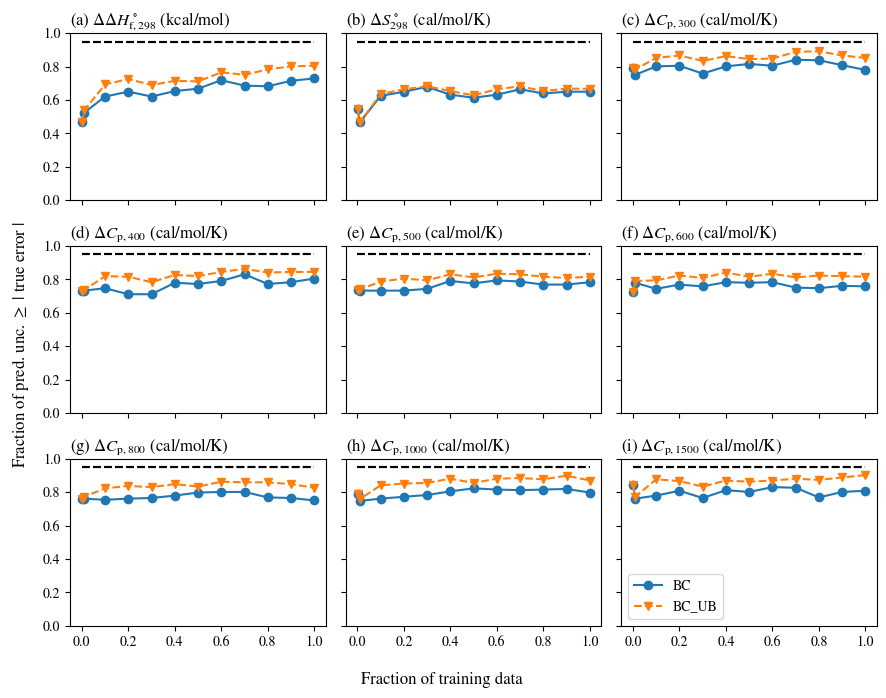

In [6]:
run_dirs_to_plot = ["BC", "BC_UB"]

fig, axs = plt.subplots(nrows=3, ncols=3, sharey=True, sharex=True, figsize=(9, 7))
bins = 20

counter = 0

for run_dir in run_dirs:
    if run_dirs[run_dir] in run_dirs_to_plot:
        ax = axs.flat[0]
        label = "bounded_HBI_H298 (kcal/mol)"
        ax.plot([0, 1], [0.95, 0.95], "k--")
        ax.plot(result_df.loc[result_df["run_dir"]==run_dir, "fraction of training"], result_df.loc[result_df["run_dir"]==run_dir, label], linestyle=linestyles[counter], marker=markers[counter])
        ax.set_ylim([0, 1])
        ax.set_title("(a) $\Delta\Delta H^\circ_\mathrm{f,298}$ (kcal/mol)", loc="left")

        ax = axs.flat[1]
        label = "bounded_HBI_Sint298 (cal/mol/K)"
        ax.plot([0, 1], [0.95, 0.95], "k--")
        ax.plot(result_df.loc[result_df["run_dir"]==run_dir, "fraction of training"], result_df.loc[result_df["run_dir"]==run_dir, label], linestyle=linestyles[counter], marker=markers[counter])
        ax.set_ylim([0, 1])
        ax.set_title("(b) $\Delta S^\circ_\mathrm{298}$ (cal/mol/K)", loc="left")

        for i, (ax, T) in enumerate(zip(axs.flat[2:], Ts)):
            label = f"bounded_HBI_Cp{T} (cal/mol/K)"
            ax.plot([0, 1], [0.95, 0.95], "k--")
            ax.plot(result_df.loc[result_df["run_dir"]==run_dir, "fraction of training"], result_df.loc[result_df["run_dir"]==run_dir, label], label=run_dirs[run_dir], linestyle=linestyles[counter], marker=markers[counter])
            ax.set_ylim([0, 1])
            ax.set_title(f"({string.ascii_letters[2:][i]}) "+"$\Delta C_\mathrm{p,{" + str(T) + "}}$ (cal/mol/K)", loc="left")
            
        counter+=1

axs.flat[-1].legend()
fig.supylabel("Fraction of pred. unc. $\geq$ | true error |")
fig.supxlabel("Fraction of training data")

fig.tight_layout()
fig.savefig("../figures/bounded_uncertainty_frac_vs_training_frac.pdf", bbox_inches="tight")

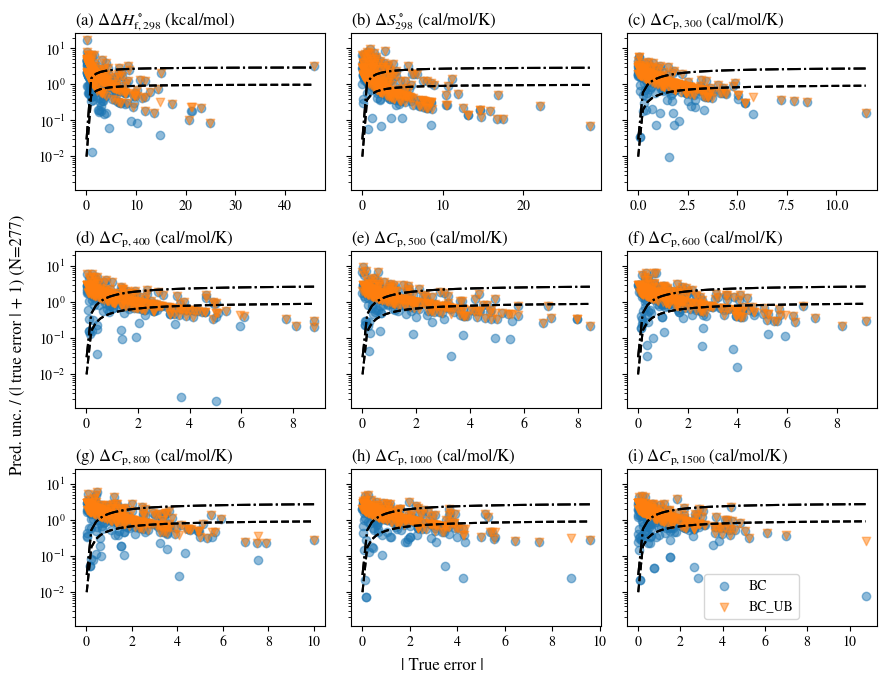

In [7]:
run_dirs_to_plot = ["BC","BC_UB"]

fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(9, 7), sharey=True)

counter = 0

for run_dir in run_dirs:
    if run_dirs[run_dir] in run_dirs_to_plot:
        
        sidt_df = sidt_df_dict[run_dir, 1.0]
        
        ax = axs.flat[0]
        label = "HBI_H298 (kcal/mol)"
        true_ys = test_df[label].values
        pred_ys = sidt_df[label].values
        pred_uncs = sidt_df["unc_"+label].values
        true_errs = np.abs(pred_ys - true_ys)
        ax.scatter(true_errs, pred_uncs / (true_errs + 1), label=run_dirs[run_dir], marker=markers[counter], alpha=0.5)
        xs = np.linspace(1e-2, max(true_errs), 50)
        ax.plot(xs, 3*xs / (xs + 1), "k-.")
        ax.plot(xs, xs / (xs + 1), "k--")
        ax.set_yscale("log")
        # ax.set_xscale("log")
        ax.set_title("(a) $\Delta\Delta H^\circ_\mathrm{f,298}$ (kcal/mol)", loc="left")

        ax = axs.flat[1]
        label = "HBI_Sint298 (cal/mol/K)"
        true_ys = test_df[label]
        pred_ys = sidt_df[label]
        pred_uncs = sidt_df["unc_"+label].values
        true_errs = np.abs(pred_ys - true_ys)
        ax.scatter(true_errs, pred_uncs / (true_errs + 1), label=run_dirs[run_dir], marker=markers[counter], alpha=0.5)
        xs = np.linspace(1e-2, max(true_errs), 50)
        ax.plot(xs, 3*xs / (xs + 1), "k-.")
        ax.plot(xs, xs / (xs + 1), "k--")
        ax.set_yscale("log")
        # ax.set_xscale("log")
        ax.set_title("(b) $\Delta S^\circ_\mathrm{298}$ (cal/mol/K)", loc="left")

        for i, (ax, T) in enumerate(zip(axs.flat[2:], Ts)):
            label = f"HBI_Cp{T} (cal/mol/K)"
            true_ys = test_df[label]
            pred_ys = sidt_df[label]
            pred_uncs = sidt_df["unc_"+label].values
            true_errs = np.abs(pred_ys - true_ys)
            ax.scatter(true_errs, pred_uncs / (true_errs + 1), label=run_dirs[run_dir], marker=markers[counter], alpha=0.5)
            xs = np.linspace(1e-2, max(true_errs), 50)
            ax.plot(xs, 3*xs / (xs + 1), "k-.")
            ax.plot(xs, xs / (xs + 1), "k--")
            ax.set_title(f"({string.ascii_letters[2:][i]}) "+"$\Delta C_\mathrm{p,{" + str(T) + "}}$ (cal/mol/K)", loc="left")
            
        counter += 1

axs.flat[-1].legend()
fig.supylabel(f"Pred. unc. / (| true error | + 1) (N={len(test_df.index)})")
fig.supxlabel(f"| True error |", y=0.03)
fig.tight_layout()

fig.savefig("../figures/sidt_unc_div_true_error_vs_true_error_BC_vs_BC_UB.pdf", bbox_inches="tight")

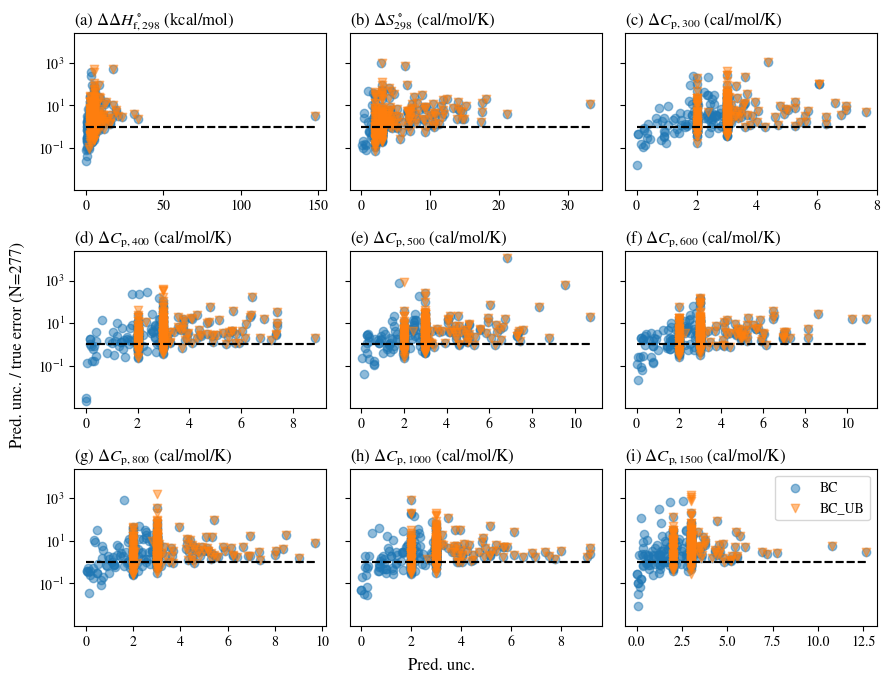

In [8]:
run_dirs_to_plot = ["BC","BC_UB"]

fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(9, 7), sharey=True)

counter = 0

for run_dir in run_dirs:
    if run_dirs[run_dir] in run_dirs_to_plot:
        
        sidt_df = sidt_df_dict[run_dir, 1.0]
        
        ax = axs.flat[0]
        label = "HBI_H298 (kcal/mol)"
        true_ys = test_df[label].values
        pred_ys = sidt_df[label].values
        pred_uncs = sidt_df["unc_"+label].values
        true_errs = np.abs(pred_ys - true_ys)
        ax.scatter(pred_uncs, pred_uncs / true_errs, label=run_dirs[run_dir], marker=markers[counter], alpha=0.5)
        ax.plot([0, max(pred_uncs)], [1, 1], "k--")
        ax.set_yscale("log")
        ax.set_title("(a) $\Delta\Delta H^\circ_\mathrm{f,298}$ (kcal/mol)", loc="left")

        ax = axs.flat[1]
        label = "HBI_Sint298 (cal/mol/K)"
        true_ys = test_df[label]
        pred_ys = sidt_df[label]
        pred_uncs = sidt_df["unc_"+label].values
        true_errs = np.abs(pred_ys - true_ys)
        ax.scatter(pred_uncs, pred_uncs / true_errs, label=run_dirs[run_dir], marker=markers[counter], alpha=0.5)
        ax.plot([0, max(pred_uncs)], [1, 1], "k--")
        ax.set_yscale("log")
        ax.set_title("(b) $\Delta S^\circ_\mathrm{298}$ (cal/mol/K)", loc="left")

        for i, (ax, T) in enumerate(zip(axs.flat[2:], Ts)):
            label = f"HBI_Cp{T} (cal/mol/K)"
            true_ys = test_df[label]
            pred_ys = sidt_df[label]
            pred_uncs = sidt_df["unc_"+label].values
            true_errs = np.abs(pred_ys - true_ys)
            ax.scatter(pred_uncs, pred_uncs / true_errs, label=run_dirs[run_dir], marker=markers[counter], alpha=0.5)
            ax.plot([0, max(pred_uncs)], [1, 1], "k--")
            ax.set_yscale("log")
            ax.set_title(f"({string.ascii_letters[2:][i]}) "+"$\Delta C_\mathrm{p,{" + str(T) + "}}$ (cal/mol/K)", loc="left")
            
        counter += 1

axs.flat[-1].legend()
fig.supylabel(f"Pred. unc. / true error (N={len(test_df.index)})")
fig.supxlabel(f"Pred. unc.", y=0.03)
fig.tight_layout()

fig.savefig("../figures/sidt_unc_div_true_error_vs_pred_unc_BC_vs_BC_UB.pdf", bbox_inches="tight")

In [9]:
sidt_df = sidt_df_dict["../models/split-random_run-basecase", 1.0]
temp_sidt_df = sidt_df

In [10]:
for column in test_df.columns:
    if column.startswith("HBI_"):
        true_ys = test_df[column]
        pred_ys = sidt_df[column]
        temp_sidt_df[f"err_{column}"] = (pred_ys - true_ys).abs()
temp_sidt_df.sort_values("err_HBI_H298 (kcal/mol)", ascending=False)

,resonance_radical_smiles,HBI_H298 (kcal/mol),unc_HBI_H298 (kcal/mol),HBI_Sint298 (cal/mol/K),unc_HBI_Sint298 (cal/mol/K),HBI_Cp300 (cal/mol/K),unc_HBI_Cp300 (cal/mol/K),HBI_Cp400 (cal/mol/K),unc_HBI_Cp400 (cal/mol/K),HBI_Cp500 (cal/mol/K),...,comment,err_HBI_H298 (kcal/mol),err_HBI_Sint298 (cal/mol/K),err_HBI_Cp300 (cal/mol/K),err_HBI_Cp400 (cal/mol/K),err_HBI_Cp500 (cal/mol/K),err_HBI_Cp600 (cal/mol/K),err_HBI_Cp800 (cal/mol/K),err_HBI_Cp1000 (cal/mol/K),err_HBI_Cp1500 (cal/mol/K)
276,C1#CC=CC[CH]1,35.7554,148.08600,2.604230,2.40605,0.607198,1.47465,0.446397,2.81026,0.164720,...,(RJ1_1R-inRing_Ext-1R-R_Ext-2R!H-R_N-Sp-3R!H=2...,45.904873,2.377214,1.265635,2.483779,1.273145,2.004277,2.554961,3.660969,4.375063
53,[CH2]CC(OO)OCOO,126.8990,2.20000,20.270800,2.00000,6.503800,2.00000,2.409400,2.00000,-0.850670,...,(RJ1_N-1R-inRing_1R->C_Ext-1C-R_Sp-2R!H-1C_2R!...,24.856954,17.475183,11.483280,8.789737,6.717871,5.466980,3.431782,1.567887,2.273252
102,C[CH]C(OO)OCOO,100.7020,5.20000,1.113270,3.00000,2.582710,3.00000,1.555660,3.00000,0.083474,...,(RJ1_N-1R-inRing_1R->C_Ext-1C-R_Sp-2R!H-1C_2R!...,23.131523,1.098777,3.359091,3.268447,2.827348,3.003282,3.637329,2.869986,0.890340
217,C=C(C)CC1C=C[CH]CC1C,104.5210,4.10192,-0.200247,6.73160,1.191230,6.08767,0.748535,5.66371,-0.354183,...,(RJ1_1R-inRing_Ext-1R-R_Ext-2R!H-R_Sp-3R!H=2R!...,21.314184,1.546693,0.059406,1.391526,1.919432,1.671404,1.531497,1.483256,0.757446
216,C=C(C)CC1[CH]C=CCC1C,104.5210,4.10192,-0.200247,6.73160,1.191230,6.08767,0.748535,5.66371,-0.354183,...,(RJ1_1R-inRing_Ext-1R-R_Ext-2R!H-R_Sp-3R!H=2R!...,21.064184,1.546693,0.059406,1.391526,1.819432,1.671404,1.531497,1.483256,0.757446
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
191,C=C(C)COOC1[CH]C=C(C)CC1,82.3101,5.20000,-4.645890,3.00000,-0.159216,3.00000,-2.737050,3.00000,-4.640210,...,(RJ1_1R-inRing_Ext-1R-R_Ext-2R!H-R_Sp-3R!H=2R!...,0.066289,0.599159,1.784492,0.945588,0.164841,0.246305,0.434705,0.641082,0.924897
248,C=C=C(C)CO[O],85.7620,4.03520,-2.109300,5.70044,-1.866680,5.28202,-3.464020,3.95415,-4.514610,...,(RJ1_N-1R-inRing_N-1R->C_Ext-1HNO-R_N-2R!H->C_...,0.045153,22.113275,0.347901,1.188831,1.962960,2.340398,2.563277,2.888510,3.523415
96,COC=C(C)[C](C)C=O,84.2240,17.24010,-4.971650,4.55568,-3.536770,3.32771,-5.384640,2.52975,-5.918930,...,(RJ1_N-1R-inRing_1R->C_Ext-1C-R_Sp-2R!H-1C_2R!...,0.031886,3.737532,1.073372,0.696314,0.395106,0.090049,0.450903,0.712840,1.266735
72,[CH2]C(=O)O,99.3750,3.30681,-2.540360,6.97298,1.320820,2.51472,1.004260,2.50327,0.439474,...,(RJ1_N-1R-inRing_1R->C_Ext-1C-R_Sp-2R!H-1C_2R!...,0.013728,1.286332,0.599436,0.493633,0.315415,0.180997,0.073997,0.059490,0.099772


# Plot: BC_UB vs. AP_UB

## RMSE/MAE vs. tree size

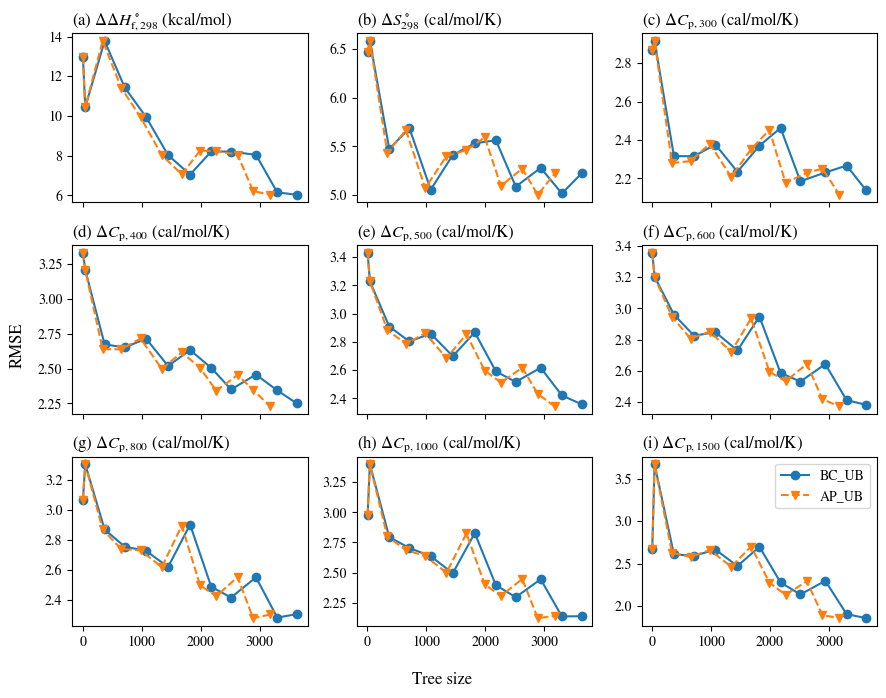

In [11]:
run_dirs_to_plot = ["BC_UB", "AP_UB"]

fig, axs = plt.subplots(nrows=3, ncols=3, sharex=True, figsize=(9, 7))

counter = 0

for run_dir in run_dirs:
    if run_dirs[run_dir] in run_dirs_to_plot:
        ax = axs.flat[0]
        label = "rmse_HBI_H298 (kcal/mol)"
        ax.plot(result_df.loc[result_df["run_dir"]==run_dir, "tree_size"], result_df.loc[result_df["run_dir"]==run_dir, label], label=run_dirs[run_dir], linestyle=linestyles[counter], marker=markers[counter])
        ax.set_title("(a) $\Delta\Delta H^\circ_\mathrm{f,298}$ (kcal/mol)", loc="left")

        ax = axs.flat[1]
        label = "rmse_HBI_Sint298 (cal/mol/K)"
        ax.plot(result_df.loc[result_df["run_dir"]==run_dir, "tree_size"], result_df.loc[result_df["run_dir"]==run_dir, label], label=run_dirs[run_dir], linestyle=linestyles[counter], marker=markers[counter])
        ax.set_title("(b) $\Delta S^\circ_\mathrm{298}$ (cal/mol/K)", loc="left")

        for i, (ax, T) in enumerate(zip(axs.flat[2:], Ts)):
            label = f"rmse_HBI_Cp{T} (cal/mol/K)"
            ax.plot(result_df.loc[result_df["run_dir"]==run_dir, "tree_size"], result_df.loc[result_df["run_dir"]==run_dir, label], label=run_dirs[run_dir], linestyle=linestyles[counter], marker=markers[counter])
            ax.set_title(f"({string.ascii_letters[2:][i]}) "+"$\Delta C_\mathrm{p,{" + str(T) + "}}$ (cal/mol/K)", loc="left")

        counter += 1

axs.flat[-1].legend()
fig.supylabel(f"RMSE")
fig.supxlabel(f"Tree size")

fig.tight_layout()
fig.savefig("../figures/rmse_vs_tree_size_BC_vs_AP.pdf", bbox_inches="tight")

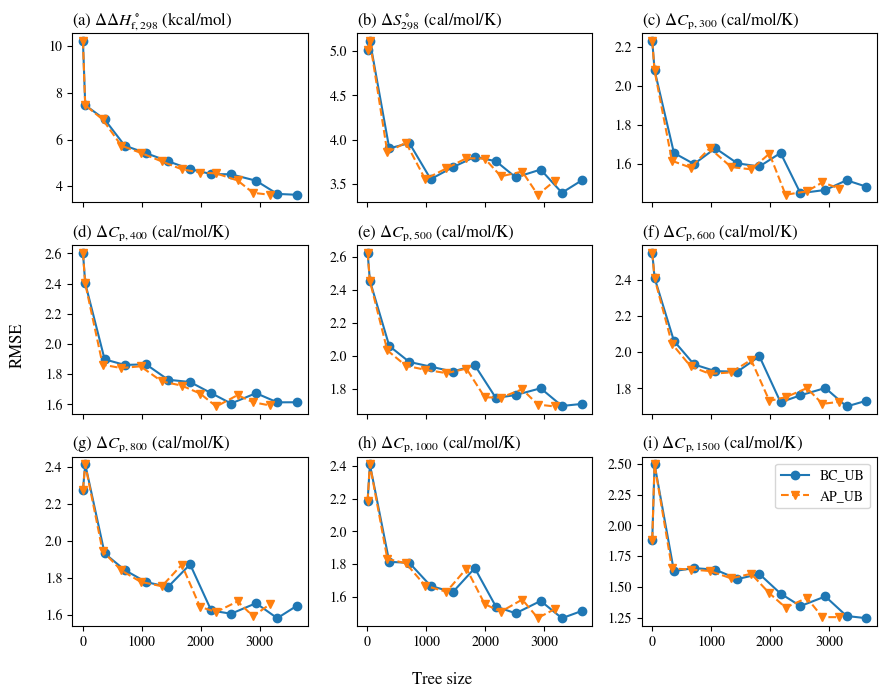

In [12]:
run_dirs_to_plot = ["BC_UB", "AP_UB"]

fig, axs = plt.subplots(nrows=3, ncols=3, sharex=True, figsize=(9, 7))

counter = 0

for run_dir in run_dirs:
    if run_dirs[run_dir] in run_dirs_to_plot:
        ax = axs.flat[0]
        label = "mae_HBI_H298 (kcal/mol)"
        ax.plot(result_df.loc[result_df["run_dir"]==run_dir, "tree_size"], result_df.loc[result_df["run_dir"]==run_dir, label], label=run_dirs[run_dir], linestyle=linestyles[counter], marker=markers[counter])
        ax.set_title("(a) $\Delta\Delta H^\circ_\mathrm{f,298}$ (kcal/mol)", loc="left")

        ax = axs.flat[1]
        label = "mae_HBI_Sint298 (cal/mol/K)"
        ax.plot(result_df.loc[result_df["run_dir"]==run_dir, "tree_size"], result_df.loc[result_df["run_dir"]==run_dir, label], label=run_dirs[run_dir], linestyle=linestyles[counter], marker=markers[counter])
        ax.set_title("(b) $\Delta S^\circ_\mathrm{298}$ (cal/mol/K)", loc="left")

        for i, (ax, T) in enumerate(zip(axs.flat[2:], Ts)):
            label = f"mae_HBI_Cp{T} (cal/mol/K)"
            ax.plot(result_df.loc[result_df["run_dir"]==run_dir, "tree_size"], result_df.loc[result_df["run_dir"]==run_dir, label], label=run_dirs[run_dir], linestyle=linestyles[counter], marker=markers[counter])
            ax.set_title(f"({string.ascii_letters[2:][i]}) "+"$\Delta C_\mathrm{p,{" + str(T) + "}}$ (cal/mol/K)", loc="left")

        counter += 1

axs.flat[-1].legend()
fig.supylabel(f"RMSE")
fig.supxlabel(f"Tree size")

fig.tight_layout()
fig.savefig("../figures/mae_vs_tree_size_BC_vs_AP.pdf", bbox_inches="tight")

## RMSE/MAE vs. training fraction

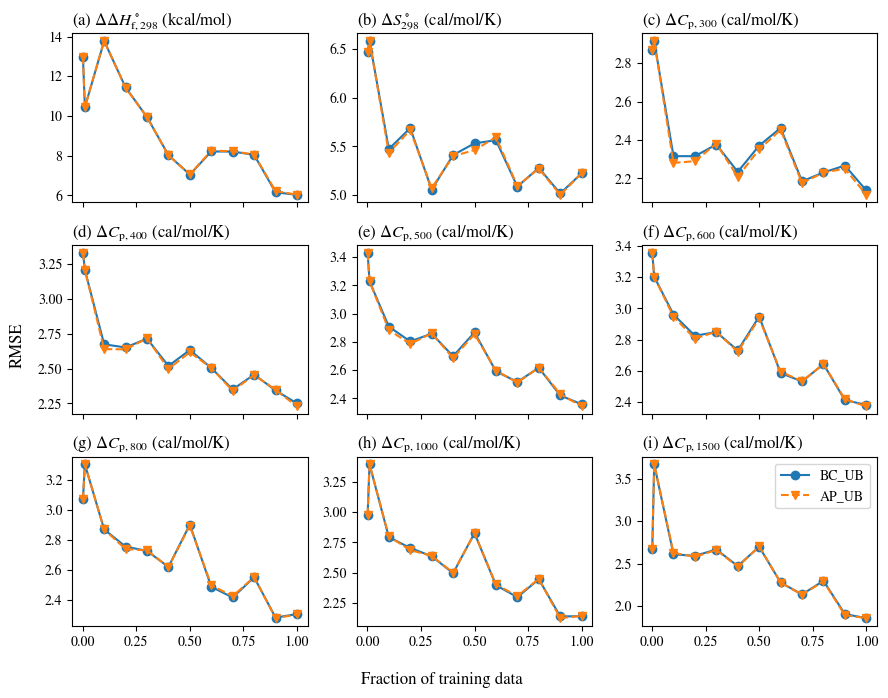

In [13]:
run_dirs_to_plot = ["BC_UB", "AP_UB"]

fig, axs = plt.subplots(nrows=3, ncols=3, sharex=True, figsize=(9, 7))

counter = 0

for run_dir in run_dirs:
    if run_dirs[run_dir] in run_dirs_to_plot:
        ax = axs.flat[0]
        label = "rmse_HBI_H298 (kcal/mol)"
        ax.plot(result_df.loc[result_df["run_dir"]==run_dir, "fraction of training"], result_df.loc[result_df["run_dir"]==run_dir, label], label=run_dirs[run_dir], linestyle=linestyles[counter], marker=markers[counter])
        ax.set_title("(a) $\Delta\Delta H^\circ_\mathrm{f,298}$ (kcal/mol)", loc="left")

        ax = axs.flat[1]
        label = "rmse_HBI_Sint298 (cal/mol/K)"
        ax.plot(result_df.loc[result_df["run_dir"]==run_dir, "fraction of training"], result_df.loc[result_df["run_dir"]==run_dir, label], label=run_dirs[run_dir], linestyle=linestyles[counter], marker=markers[counter])
        ax.set_title("(b) $\Delta S^\circ_\mathrm{298}$ (cal/mol/K)", loc="left")

        for i, (ax, T) in enumerate(zip(axs.flat[2:], Ts)):
            label = f"rmse_HBI_Cp{T} (cal/mol/K)"
            ax.plot(result_df.loc[result_df["run_dir"]==run_dir, "fraction of training"], result_df.loc[result_df["run_dir"]==run_dir, label], label=run_dirs[run_dir], linestyle=linestyles[counter], marker=markers[counter])
            ax.set_title(f"({string.ascii_letters[2:][i]}) "+"$\Delta C_\mathrm{p,{" + str(T) + "}}$ (cal/mol/K)", loc="left")

        counter += 1

axs.flat[-1].legend()
fig.supylabel(f"RMSE")
fig.supxlabel(f"Fraction of training data")

fig.tight_layout()
fig.savefig("../figures/rmse_vs_training_frac_BC_vs_AP.pdf", bbox_inches="tight")

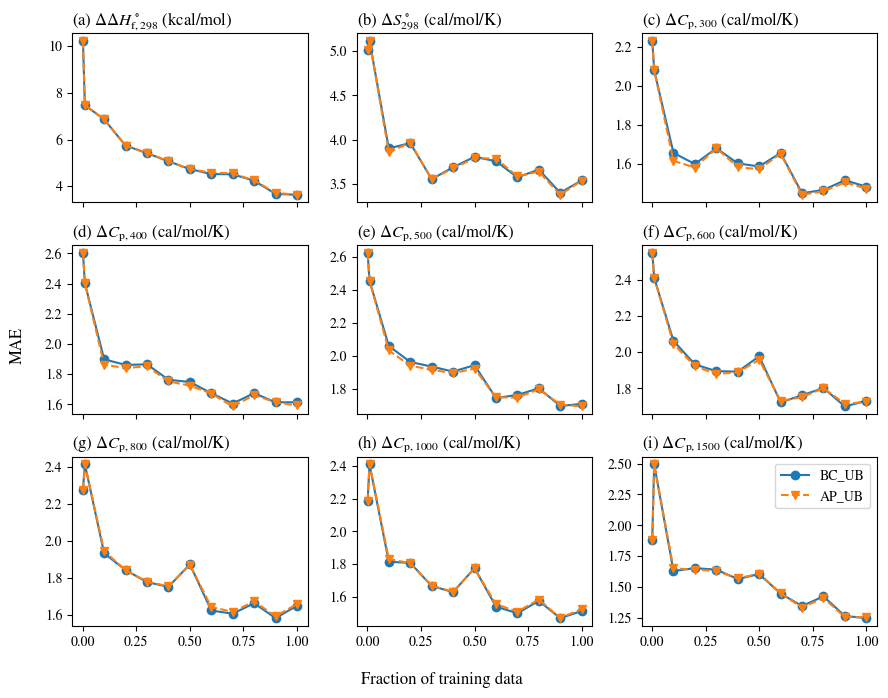

In [14]:
run_dirs_to_plot = ["BC_UB", "AP_UB"]

fig, axs = plt.subplots(nrows=3, ncols=3, sharex=True, figsize=(9, 7))

counter = 0

for run_dir in run_dirs:
    if run_dirs[run_dir] in run_dirs_to_plot:
        ax = axs.flat[0]
        label = "mae_HBI_H298 (kcal/mol)"
        ax.plot(result_df.loc[result_df["run_dir"]==run_dir, "fraction of training"], result_df.loc[result_df["run_dir"]==run_dir, label], label=run_dirs[run_dir], linestyle=linestyles[counter], marker=markers[counter])
        ax.set_title("(a) $\Delta\Delta H^\circ_\mathrm{f,298}$ (kcal/mol)", loc="left")

        ax = axs.flat[1]
        label = "mae_HBI_Sint298 (cal/mol/K)"
        ax.plot(result_df.loc[result_df["run_dir"]==run_dir, "fraction of training"], result_df.loc[result_df["run_dir"]==run_dir, label], label=run_dirs[run_dir], linestyle=linestyles[counter], marker=markers[counter])
        ax.set_title("(b) $\Delta S^\circ_\mathrm{298}$ (cal/mol/K)", loc="left")

        for i, (ax, T) in enumerate(zip(axs.flat[2:], Ts)):
            label = f"mae_HBI_Cp{T} (cal/mol/K)"
            ax.plot(result_df.loc[result_df["run_dir"]==run_dir, "fraction of training"], result_df.loc[result_df["run_dir"]==run_dir, label], label=run_dirs[run_dir], linestyle=linestyles[counter], marker=markers[counter])
            ax.set_title(f"({string.ascii_letters[2:][i]}) "+"$\Delta C_\mathrm{p,{" + str(T) + "}}$ (cal/mol/K)", loc="left")

        counter += 1

axs.flat[-1].legend()
fig.supylabel(f"MAE")
fig.supxlabel(f"Fraction of training data")

fig.tight_layout()
fig.savefig("../figures/mae_vs_training_frac_BC_vs_AP.pdf", bbox_inches="tight")

# MP vs. AP

## RMSE/MAE vs. tree size

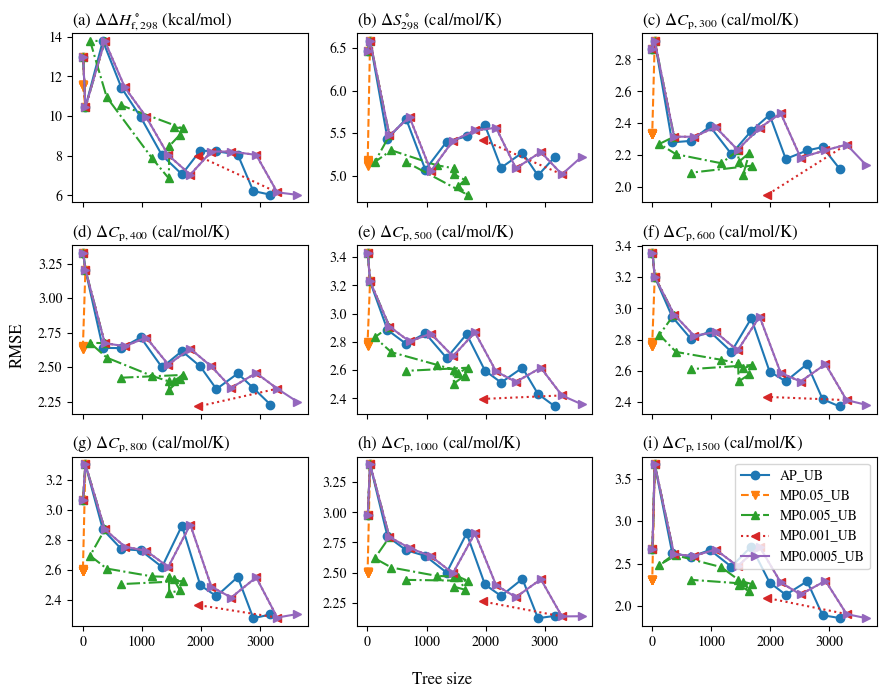

In [15]:
run_dirs_to_plot = ["MP0.05_UB", "MP0.005_UB", "MP0.001_UB", "MP0.0005_UB", "AP_UB"]

fig, axs = plt.subplots(nrows=3, ncols=3, sharex=True, figsize=(9, 7))

counter = 0

for run_dir in run_dirs:
    if run_dirs[run_dir] in run_dirs_to_plot:
        ax = axs.flat[0]
        label = "rmse_HBI_H298 (kcal/mol)"
        ax.plot(result_df.loc[result_df["run_dir"]==run_dir, "tree_size"], result_df.loc[result_df["run_dir"]==run_dir, label], label=run_dirs[run_dir], linestyle=linestyles[counter], marker=markers[counter])
        ax.set_title("(a) $\Delta\Delta H^\circ_\mathrm{f,298}$ (kcal/mol)", loc="left")

        ax = axs.flat[1]
        label = "rmse_HBI_Sint298 (cal/mol/K)"
        ax.plot(result_df.loc[result_df["run_dir"]==run_dir, "tree_size"], result_df.loc[result_df["run_dir"]==run_dir, label], label=run_dirs[run_dir], linestyle=linestyles[counter], marker=markers[counter])
        ax.set_title("(b) $\Delta S^\circ_\mathrm{298}$ (cal/mol/K)", loc="left")

        for i, (ax, T) in enumerate(zip(axs.flat[2:], Ts)):
            label = f"rmse_HBI_Cp{T} (cal/mol/K)"
            ax.plot(result_df.loc[result_df["run_dir"]==run_dir, "tree_size"], result_df.loc[result_df["run_dir"]==run_dir, label], label=run_dirs[run_dir], linestyle=linestyles[counter], marker=markers[counter])
            ax.set_title(f"({string.ascii_letters[2:][i]}) "+"$\Delta C_\mathrm{p,{" + str(T) + "}}$ (cal/mol/K)", loc="left")

        counter += 1

axs.flat[-1].legend()
fig.supylabel(f"RMSE")
fig.supxlabel(f"Tree size")

fig.tight_layout()
fig.savefig("../figures/rmse_vs_tree_size_AP_vs_MP.pdf", bbox_inches="tight")

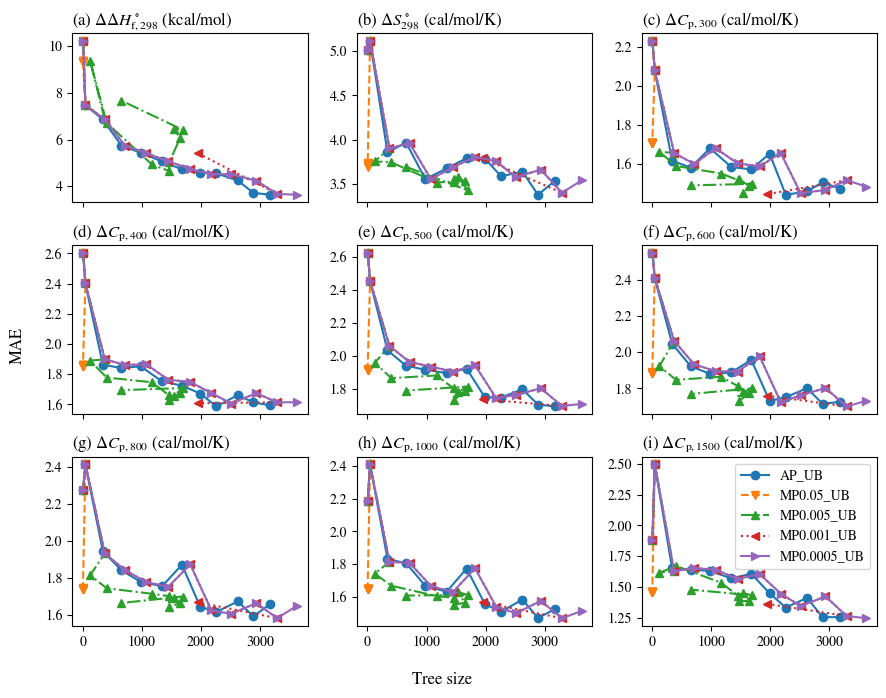

In [16]:
run_dirs_to_plot = ["MP0.05_UB", "MP0.005_UB", "MP0.001_UB", "MP0.0005_UB", "AP_UB"]

fig, axs = plt.subplots(nrows=3, ncols=3, sharex=True, figsize=(9, 7))

counter = 0

for run_dir in run_dirs:
    if run_dirs[run_dir] in run_dirs_to_plot:
        ax = axs.flat[0]
        label = "mae_HBI_H298 (kcal/mol)"
        ax.plot(result_df.loc[result_df["run_dir"]==run_dir, "tree_size"], result_df.loc[result_df["run_dir"]==run_dir, label], label=run_dirs[run_dir], linestyle=linestyles[counter], marker=markers[counter])
        ax.set_title("(a) $\Delta\Delta H^\circ_\mathrm{f,298}$ (kcal/mol)", loc="left")

        ax = axs.flat[1]
        label = "mae_HBI_Sint298 (cal/mol/K)"
        ax.plot(result_df.loc[result_df["run_dir"]==run_dir, "tree_size"], result_df.loc[result_df["run_dir"]==run_dir, label], label=run_dirs[run_dir], linestyle=linestyles[counter], marker=markers[counter])
        ax.set_title("(b) $\Delta S^\circ_\mathrm{298}$ (cal/mol/K)", loc="left")

        for i, (ax, T) in enumerate(zip(axs.flat[2:], Ts)):
            label = f"mae_HBI_Cp{T} (cal/mol/K)"
            ax.plot(result_df.loc[result_df["run_dir"]==run_dir, "tree_size"], result_df.loc[result_df["run_dir"]==run_dir, label], label=run_dirs[run_dir], linestyle=linestyles[counter], marker=markers[counter])
            ax.set_title(f"({string.ascii_letters[2:][i]}) "+"$\Delta C_\mathrm{p,{" + str(T) + "}}$ (cal/mol/K)", loc="left")

        counter += 1

axs.flat[-1].legend()
fig.supylabel(f"MAE")
fig.supxlabel(f"Tree size")

fig.tight_layout()
fig.savefig("../figures/mae_vs_tree_size_AP_vs_MP.pdf", bbox_inches="tight")

## RMSE/MAE vs. training fraction

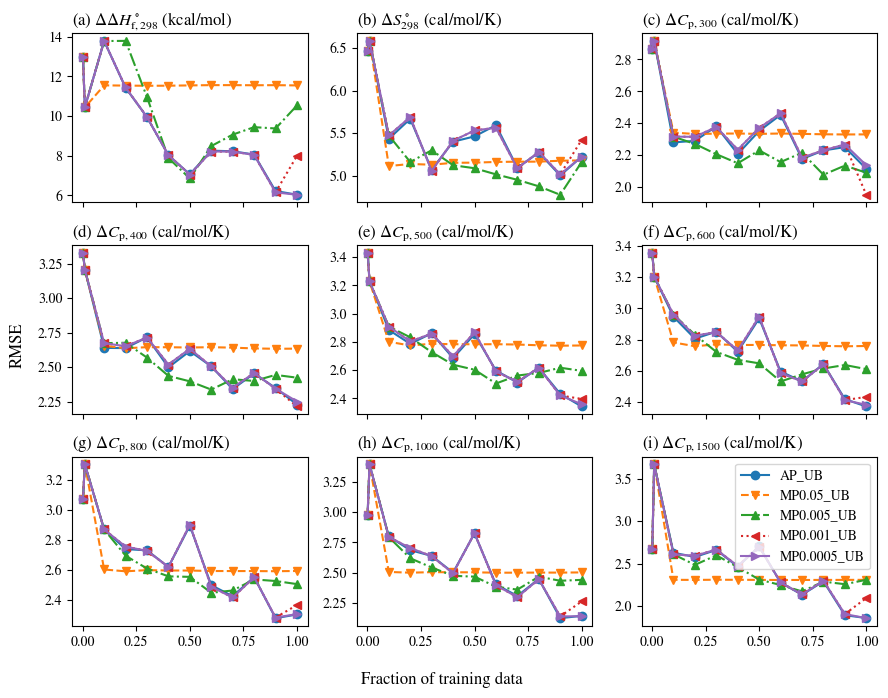

In [17]:
run_dirs_to_plot = ["MP0.05_UB", "MP0.005_UB", "MP0.001_UB", "MP0.0005_UB", "AP_UB"]

fig, axs = plt.subplots(nrows=3, ncols=3, sharex=True, figsize=(9, 7))

counter = 0

for run_dir in run_dirs:
    if run_dirs[run_dir] in run_dirs_to_plot:
        ax = axs.flat[0]
        label = "rmse_HBI_H298 (kcal/mol)"
        ax.plot(result_df.loc[result_df["run_dir"]==run_dir, "fraction of training"], result_df.loc[result_df["run_dir"]==run_dir, label], label=run_dirs[run_dir], linestyle=linestyles[counter], marker=markers[counter])
        ax.set_title("(a) $\Delta\Delta H^\circ_\mathrm{f,298}$ (kcal/mol)", loc="left")

        ax = axs.flat[1]
        label = "rmse_HBI_Sint298 (cal/mol/K)"
        ax.plot(result_df.loc[result_df["run_dir"]==run_dir, "fraction of training"], result_df.loc[result_df["run_dir"]==run_dir, label], label=run_dirs[run_dir], linestyle=linestyles[counter], marker=markers[counter])
        ax.set_title("(b) $\Delta S^\circ_\mathrm{298}$ (cal/mol/K)", loc="left")

        for i, (ax, T) in enumerate(zip(axs.flat[2:], Ts)):
            label = f"rmse_HBI_Cp{T} (cal/mol/K)"
            ax.plot(result_df.loc[result_df["run_dir"]==run_dir, "fraction of training"], result_df.loc[result_df["run_dir"]==run_dir, label], label=run_dirs[run_dir], linestyle=linestyles[counter], marker=markers[counter])
            ax.set_title(f"({string.ascii_letters[2:][i]}) "+"$\Delta C_\mathrm{p,{" + str(T) + "}}$ (cal/mol/K)", loc="left")

        counter += 1

axs.flat[-1].legend()
fig.supylabel(f"RMSE")
fig.supxlabel(f"Fraction of training data")

fig.tight_layout()
fig.savefig("../figures/rmse_vs_training_frac_AP_vs_MP.pdf", bbox_inches="tight")

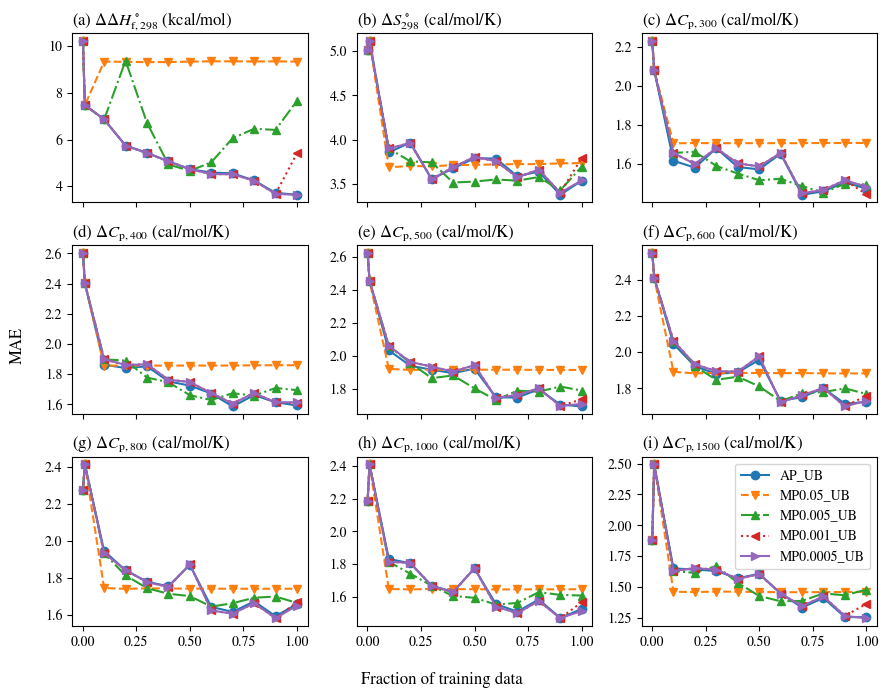

In [18]:
run_dirs_to_plot = ["MP0.05_UB", "MP0.005_UB", "MP0.001_UB", "MP0.0005_UB", "AP_UB"]

fig, axs = plt.subplots(nrows=3, ncols=3, sharex=True, figsize=(9, 7))

counter = 0

for run_dir in run_dirs:
    if run_dirs[run_dir] in run_dirs_to_plot:
        ax = axs.flat[0]
        label = "mae_HBI_H298 (kcal/mol)"
        ax.plot(result_df.loc[result_df["run_dir"]==run_dir, "fraction of training"], result_df.loc[result_df["run_dir"]==run_dir, label], label=run_dirs[run_dir], linestyle=linestyles[counter], marker=markers[counter])
        ax.set_title("(a) $\Delta\Delta H^\circ_\mathrm{f,298}$ (kcal/mol)", loc="left")

        ax = axs.flat[1]
        label = "mae_HBI_Sint298 (cal/mol/K)"
        ax.plot(result_df.loc[result_df["run_dir"]==run_dir, "fraction of training"], result_df.loc[result_df["run_dir"]==run_dir, label], label=run_dirs[run_dir], linestyle=linestyles[counter], marker=markers[counter])
        ax.set_title("(b) $\Delta S^\circ_\mathrm{298}$ (cal/mol/K)", loc="left")

        for i, (ax, T) in enumerate(zip(axs.flat[2:], Ts)):
            label = f"mae_HBI_Cp{T} (cal/mol/K)"
            ax.plot(result_df.loc[result_df["run_dir"]==run_dir, "fraction of training"], result_df.loc[result_df["run_dir"]==run_dir, label], label=run_dirs[run_dir], linestyle=linestyles[counter], marker=markers[counter])
            ax.set_title(f"({string.ascii_letters[2:][i]}) "+"$\Delta C_\mathrm{p,{" + str(T) + "}}$ (cal/mol/K)", loc="left")

        counter += 1

axs.flat[-1].legend()
fig.supylabel(f"MAE")
fig.supxlabel(f"Fraction of training data")

fig.tight_layout()
fig.savefig("../figures/mae_vs_training_frac_AP_vs_MP.pdf", bbox_inches="tight")

# Other

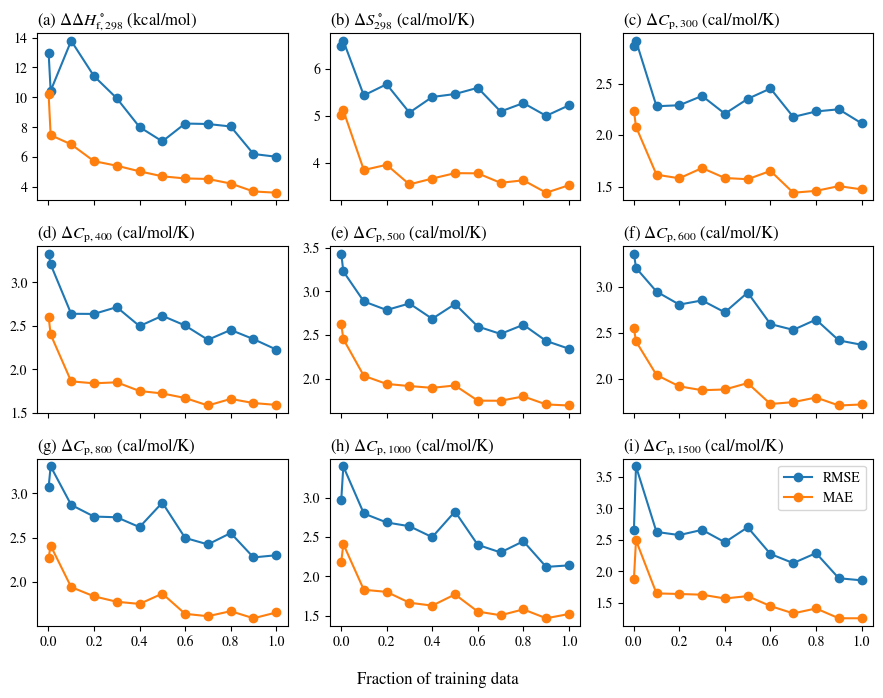

In [19]:
fig, axs = plt.subplots(nrows=3, ncols=3, sharex=True, figsize=(9, 7))
bins = 20

run_dir = "../models/split-random_run-aleatoric_prepruning-upper_bound"

ax = axs.flat[0]
label = "HBI_H298 (kcal/mol)"
ax.plot(result_df.loc[result_df["run_dir"]==run_dir, "fraction of training"], result_df.loc[result_df["run_dir"]==run_dir, "rmse_"+label], "-o")
ax.plot(result_df.loc[result_df["run_dir"]==run_dir, "fraction of training"], result_df.loc[result_df["run_dir"]==run_dir, "mae_"+label], "-o")
ax.set_title("(a) $\Delta\Delta H^\circ_\mathrm{f,298}$ (kcal/mol)", loc="left")

ax = axs.flat[1]
label = "HBI_Sint298 (cal/mol/K)"
ax.plot(result_df.loc[result_df["run_dir"]==run_dir, "fraction of training"], result_df.loc[result_df["run_dir"]==run_dir, "rmse_"+label], "-o")
ax.plot(result_df.loc[result_df["run_dir"]==run_dir, "fraction of training"], result_df.loc[result_df["run_dir"]==run_dir, "mae_"+label], "-o")
ax.set_title("(b) $\Delta S^\circ_\mathrm{298}$ (cal/mol/K)", loc="left")

for i, (ax, T) in enumerate(zip(axs.flat[2:], Ts)):
    label = f"HBI_Cp{T} (cal/mol/K)"
    ax.plot(result_df.loc[result_df["run_dir"]==run_dir, "fraction of training"], result_df.loc[result_df["run_dir"]==run_dir, "rmse_"+label], "-o", label="RMSE")
    ax.plot(result_df.loc[result_df["run_dir"]==run_dir, "fraction of training"], result_df.loc[result_df["run_dir"]==run_dir, "mae_"+label], "-o", label="MAE")
    ax.set_title(f"({string.ascii_letters[2:][i]}) "+"$\Delta C_\mathrm{p,{" + str(T) + "}}$ (cal/mol/K)", loc="left")

axs.flat[-1].legend()
fig.supxlabel(f"Fraction of training data")

fig.tight_layout()
# fig.savefig("../figures/rmse_mae_vs_training_frac.pdf", bbox_inches="tight")